## Importing the required libraries

In [5]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import math, copy
from sklearn.datasets import load_boston
from scipy.special import expit
import  seaborn as sns

### Loading and Pre Processing the Titanic Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### checking and filling null values

<AxesSubplot:>

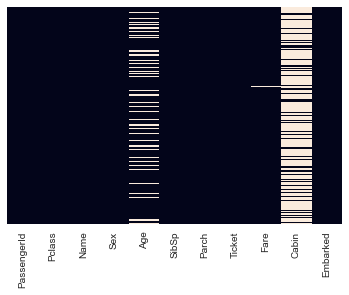

In [3]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False)

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

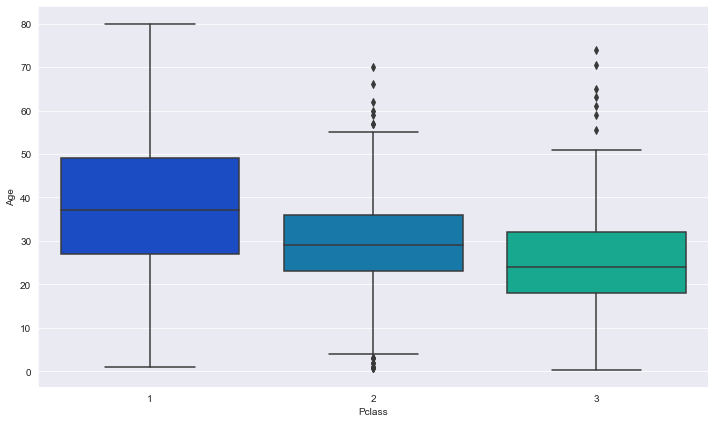

In [6]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

### We can see that Cabin has a lot of missing values and can be removed and Age is related to the Pclass column as wealthier passengers are tend to be from the same age group and same for others

In [7]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [10]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
test['Age'] = test[['Age','Pclass']].apply(impute_age,axis=1)

In [11]:
train.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Converting the categorical values to numerical and dropping Name and Ticekt as they don't have any relavance to survival

In [12]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


### Splitting the dataset into test and train with an 80:20 split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1),train['Survived'], test_size=0.20,random_state=101)

In [14]:
X_train.shape

(711, 9)

In [15]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

## Task 4: Logistic Regression using gradient descent on Titanic dataset

In [16]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [17]:
def compute_gradient_logistic(X, y, w, b):

    m,n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        f_wb_i = expit(np.dot(X[i],w) + b)
        err_i  = f_wb_i  - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m
    dj_db = dj_db/m

    return dj_db, dj_dw

### Applied Gradient descent for any number of input features

In [18]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    w = copy.deepcopy(w_in)
    b = b_in

    for i in range(num_iters):

        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

    return w, b         #return final w,b and J history for graphing

In [19]:
w_tmp  = np.zeros_like(X_train[0])
b_tmp  = 1
alph = 0.2
iters = 1500

w_out, b_out = gradient_descent(X_train, y_train, w_tmp, b_tmp, alph, iters)
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")


updated parameters: w:[-38.83933745 -28.25493844 -74.26514889 -22.38216555  -2.59028039
  68.05233027 -35.93947744   2.67474893 -10.01621665], b:-1.5428097600994284


### Checking the coeficients that our model generated, since we took nine input labels we have nine weights and a bias

In [20]:
w_out, b_out

(array([-38.83933745, -28.25493844, -74.26514889, -22.38216555,
         -2.59028039,  68.05233027, -35.93947744,   2.67474893,
        -10.01621665]),
 -1.5428097600994284)

### precision, recall, and F-measure scores on train and test set

In [21]:
y_predicted = []
m = X_test.shape[0]
y_actual = []
for i in range(m):
    y_actual.append(y_test[i])
    temp = int(expit(np.dot(X_test[i],w_out) + b_out))
    y_predicted.append(temp)

In [22]:
print(classification_report(y_actual,y_predicted))
print("Accuracy on test:",metrics.accuracy_score(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.61      0.98      0.75       107
           1       0.60      0.04      0.08        71

    accuracy                           0.61       178
   macro avg       0.60      0.51      0.41       178
weighted avg       0.60      0.61      0.48       178

Accuracy on test: 0.6067415730337079


In [23]:
y_predicted_train = []
m = X_train.shape[0]
y_actual_train = []
for i in range(m):
    y_actual_train.append(y_train[i])
    temp = int(expit(np.dot(X_train[i],w_out) + b_out))
    y_predicted_train.append(temp)

In [24]:
print(classification_report(y_actual_train,y_predicted_train))
print("Accuracy on train:",metrics.accuracy_score(y_actual_train, y_predicted_train))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77       442
           1       0.71      0.04      0.07       269

    accuracy                           0.63       711
   macro avg       0.67      0.51      0.42       711
weighted avg       0.66      0.63      0.50       711

Accuracy on train: 0.630098452883263


### It is true that since our model is trained on the training set it would have a higher accuracy for the training data